Viene variato il guadagno del fototubo dello spettrofluorimetro mantenendo lo stesso campione

In [57]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import os
import sys
import plotly.graph_objects as go 
dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')
from labbiofisica import Interpolazione, final_val
from scipy.optimize import curve_fit

In [58]:
voltaggi = np.array([500,550,600,650,700,750,800,775,725,790])
data = pd.read_csv('./data/voltaggio_fototubo_rod001.csv', sep=',',header=1,nrows=117)
data = data.iloc[:, :-1]
header = []
for v in voltaggi:
    header.append(f'λ{v}')
    header.append(f'I{v}')
data.columns = header
data.tail()

,λ500,I500,λ550,I550,λ600,I600,λ650,I650,λ700,I700,λ750,I750,λ800,I800,λ775,I775,λ725,I725,λ790,I790
112,646.950012,0.365092,646.950012,0.882395,646.950012,1.841157,646.950012,4.000661,646.950012,7.832069,646.950012,14.021564,646.950012,25.994720,646.950012,19.587435,646.950012,10.366351,646.950012,22.100004
113,647.969971,0.332417,647.969971,0.763065,647.969971,1.825262,647.969971,3.821141,647.969971,7.453328,647.969971,14.250634,647.969971,25.309944,647.969971,18.577137,647.969971,9.777984,647.969971,21.104113
114,648.840027,0.349335,648.840027,0.806869,648.840027,1.836737,648.840027,3.373553,648.840027,7.463130,648.840027,14.054100,648.840027,23.113602,648.840027,18.798872,648.840027,9.605007,648.840027,20.834089
115,649.849976,0.319576,649.849976,0.752655,649.849976,1.728781,649.849976,3.495102,649.849976,6.829227,649.849976,12.510178,649.849976,23.410215,649.849976,17.567253,649.849976,9.091236,649.849976,19.207785
116,650.859985,0.319534,650.859985,0.648037,650.859985,1.622521,650.859985,3.291862,650.859985,6.479994,650.859985,12.611630,650.859985,22.689318,650.859985,15.913680,650.859985,8.945634,650.859985,19.141430


In [59]:
from plotly.colors import sequential

fig = go.Figure()

colors = sequential.Plasma[:len(voltaggi)]  # Use the plasma color scale
for i, v in enumerate(sorted(voltaggi, reverse=True)):
    fig.add_trace(go.Scatter(
        x=data[f'λ{v}'], 
        y=data[f'I{v}'], 
        mode='lines', 
        name=f'V={v}V',
        line=dict(color=colors[i % len(colors)])  # Assign colors cyclically
    ))

fig.update_layout(
    xaxis_title='λ [nm]',
    yaxis_title='Intensità [a.u.]',
    legend_title='Guadagno [V]',
    # template='plotly_white',
    width=800,
    height=600,
    legend=dict(
        x=0.99,
        y=0.99,
        xanchor='right',
        yanchor='top')
)

fig.write_html(dir_path + '/html/plotly_fototubo.html')
fig.write_image(dir_path + '/images/plotly_fototubo.png')
fig.show()

FIT PICCHI

In [60]:
def parabola(x, x0,a,P):
    return -a*(x-x0)**2 + P


lc = []
slc = []
a = []
sa = []
P = []
sP = []

r = 5
for v in voltaggi:
    lambdas = data[f'λ{v}'].to_numpy()
    intensities = data[f'I{v}'].to_numpy()
    max_index = np.argmax(intensities)
    l = lambdas[max_index-r:max_index+r]
    i = intensities[max_index-r:max_index+r]
    popt, pcov = curve_fit(parabola, l, i, p0=[lambdas[max_index], 1, intensities[max_index]])
    λcenter, b, M = popt
    error_λcenter, error_b, error_M = np.sqrt(np.diag(pcov))
    lc.append(λcenter)
    slc.append(error_λcenter)
    a.append(b)
    sa.append(error_b)
    P.append(M)
    sP.append(error_M)

lc = np.array(lc)
slc = np.array(slc)
a = np.array(a)
sa = np.array(sa)
P = np.array(P)
sP = np.array(sP)

fit_result = pd.DataFrame({
    'V': voltaggi,
    'λcenter': lc,
    'sλcenter': slc,
    'a': a,
    'sa': sa,
    'P': P,
    'sP': sP
})

fit_result = fit_result.sort_values(by='V').reset_index(drop=True)
display(fit_result)

,V,λcenter,sλcenter,a,sa,P,sP
0,500,550.670016,0.206137,0.021198,0.003441,11.360026,0.037385
1,550,550.952030,0.185835,0.057304,0.007862,28.939933,0.084627
2,600,551.487627,0.108475,0.134646,0.011549,66.697797,0.126911
3,650,551.120935,0.136848,0.253264,0.026928,134.113793,0.295295
4,700,551.049159,0.203751,0.491049,0.071690,271.740025,0.768046
5,725,551.022582,0.168143,0.724835,0.088074,368.525008,0.944847
6,750,550.837602,0.182922,1.231859,0.119352,520.699045,1.236390
7,775,550.710964,0.163225,1.401220,0.178880,683.255953,1.941498
8,790,550.704647,0.103392,1.664810,0.134775,792.745581,1.463022
9,800,550.994044,0.154321,2.111525,0.237580,942.484601,2.552270


PLOT INTENSITIES VS VOLTAGGI

In [61]:
V = fit_result['V'] # - 500
F = fit_result['P']
sF = fit_result['sP']

def fit_functon(x, a,b,n,V0):
    return np.where(x>=V0, a*(x-V0)**n+b, 0)

popt, pcov = curve_fit(fit_functon, V, F, p0=[7.77*10**-6, 20, 3,500])
a, b, n, V0= popt
sa, sb, sn, sV0 = np.sqrt(np.diag(pcov))
print('a: ', final_val(a, sa,exp=-6))
print('b: ', final_val(b, sb))
print('n: ', final_val(n, sn))
print('V0: ', final_val(V0, sV0))


a:  (4.49 ± 44.39)e-6 
b:  39.3 ± 24.64 
n:  3.35 ± 1.5 
V0:  500.0 ± 121.86 


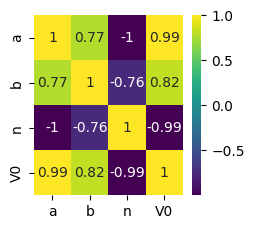

In [62]:
import seaborn as sns

param_names = ['a', 'b', 'n','V0']

pcov_normalized = pcov / np.outer(np.sqrt(np.diag(pcov)), np.sqrt(np.diag(pcov)))   

plt.figure(figsize=(8, 6))
sns.heatmap(pcov_normalized, annot=True, cmap="viridis",
            xticklabels=param_names, yticklabels=param_names)
#plt.title("Covariance Matrix")
plt.tight_layout()
plt.gcf().set_size_inches(2, 2)
plt.show()


In [64]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=V,
    y=F,
    mode='markers',
    name='Intensity',
    error_y=dict(
        type='data',
        array=sF,
        visible=True
    )
))

fit_x = np.linspace(V.min(), V.max()+20, 1000)
fit_y = fit_functon(fit_x, *popt)

fig.add_trace(go.Scatter(
    x=fit_x,
    y=fit_y,
    mode='lines',
    name='Fit Line',
    line=dict(color='red')
))

fig.update_layout(
    #xaxis_title='Voltage (V)',
    yaxis_title='Intensità (a.u.)',
    xaxis_title='Voltaggio [V]',
    # title='Intensity vs Voltage',
    width=800,
    height=600,
    # xaxis_type='log',
    #yaxis_type='log'
    legend=dict(
        x=0.01,
        y=0.99,
        xanchor='left',
        yanchor='top'
    )
)

fig.write_html(dir_path + '/html/plotly_fototubo_fit.html')
fig.write_image(dir_path + '/images/plotly_fototubo_fit.png')
fig.show()

C:\Users\jocar\AppData\Local\Temp\ipykernel_14532\2543138926.py:6: RuntimeWarning:

invalid value encountered in power

